# BIRCH聚类算法
* 高效的层次聚类法，BIRCH的全称为Balanced Iterative Reducing and Clustering using Hierarchies，直译过来就是「使用层次方法的平衡迭代规约和聚类」。该算法由时任IBM工程师TianZhang于 996年发明，详见[论文](https://www2.cs.sfu.ca/CourseCentral/459/han/papers/zhang96.pdf)
* BIRCH 最大的特点就是高效，可用于大型数据集的快速聚类。
* BIRCH 算法的核心就是基于训练样本建立了CF聚类特征树。CF聚类特征树对应的输出就是若干个CF节点，每个节点里的样本点就是一个聚类的类别。
# 总结
* BIRCH算法在建立`CF`特征树时只存储原始数据的特征信息，并不需要存储原始数据信息，内存开销上更优，计算高效。
* BIRCH算法只需要遍历一遍原始数据，而agglomerative算法在每次迭代都需要遍历一遍数据，再次突出BIRCH的高效性。
* BIRCH属于在线学习算法，并支持对流数据的聚类，开始聚类时并不需要知道所有的数据。

## 1.先导入`DIGITS`数据集，并查看前5个手写字符，一个手写字符的数据是由8x8的矩阵表示

In [1]:
import numpy as np
from sklearn import datasets
from matplotlib import pyplot as plt

digits = datasets.load_digits()
# 查看前 5 个字符
fig, axes = plt.subplots(1, 5, figsize=(12,4))
for i, image in enumerate(digits.images[:5]):
    axes[i].imshow(image, cmap=plt.cm.gray_r)
digits.images[0]


array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

## 使用scikit-learn中PCA方法完成数据降维：
`sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver='auto')`
### 其中：
* `n_components=` 表示需要保留主成分（特征）的数量。
* `copy=` 表示针对原始数据降维还是针对原始数据副本降维。当参数为 False 时，降维后的原始数据会发生改变，这里默认为 True。
* `whiten=` 白化表示将特征之间的相关性降低，并使得每个特征具有相同的方差。
* `svd_solver=` 表示奇异值分解SVD的方法。有4参数，分别是：auto, full, arpack, randomized。
* 在使用 PCA 降维时，我们也会使用到`PCA.fit()`方法。`.fit()`是`scikit-learn`训练模型的通用方法，但是该方法本身返回的是模型的参数。所以，通常我们会使用`PCA.fit_transform()`方法直接返回降维后的数据结果。

In [2]:
from sklearn.decomposition import PCA

# PCA 将数据降为 2 维
pca = PCA(n_components=2)
pca_data = pca.fit_transform(digits.data)
print(pca_data)

[[ -1.25946681  21.27488103]
 [  7.9576142  -20.76870385]
 [  6.9919211   -9.95598154]
 ...
 [ 10.80128209  -6.96025022]
 [ -4.87209931  12.42394924]
 [ -0.34439303   6.36555662]]


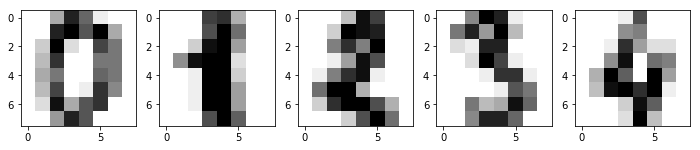

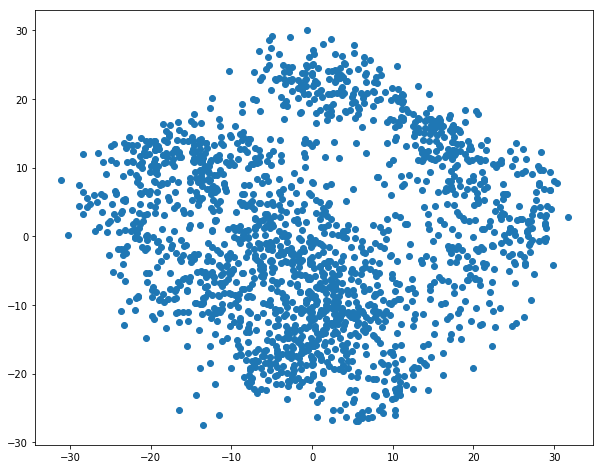

In [3]:
# 将降维后的数据绘制到二维平面中
plt.figure(figsize=(10, 8))
plt.scatter(pca_data[:,0], pca_data[:,1])
plt.show()

* 上图就是DIGITS数据集中1797个样本通过PCA降维后对应在二维平面的数据点。
* 现在，我们可以直接使用BIRCH对降维后的数据进行聚类。由于我们提前知道这是手写数字字符，所以选择聚为10类。当然，在聚类时，我们只是知道大致要聚集的类别数量，而并不知道数据对应的标签值。
### BIRCH 在`scikit-learn`对应的主要类及参数如下：
`
sklearn.cluster.Birch(threshold=0.5, branching_factor=50, n_clusters=3, compute_labels=True, copy=True)
`
### 其中：
* `threshold`: 每个`CF`的空间阈值τ。参数值越小，则`CF`特征树的规模会越大，学习时花费的时间和内存会越多。默认值是0.5，但如果样本的方差较大，则一般需要增大这个默认值。
* `branching_factor`: `CF` 树中所有节点的最大`CF`数。该参数默认为50，如果样本量非常大，一般需要增大这个默认值。
* `n_clusters`: 虽然层次聚类无需预先设定类别数量，但可以设定期望查询的类别数。

In [4]:
# 使用 BIRCH 算法得到 PCA 降维后数据的聚类结果
from sklearn.cluster import Birch

birch = Birch(n_clusters=10)
cluster_pca = birch.fit_predict(pca_data)
print(cluster_pca)

[3 0 0 ... 0 5 9]


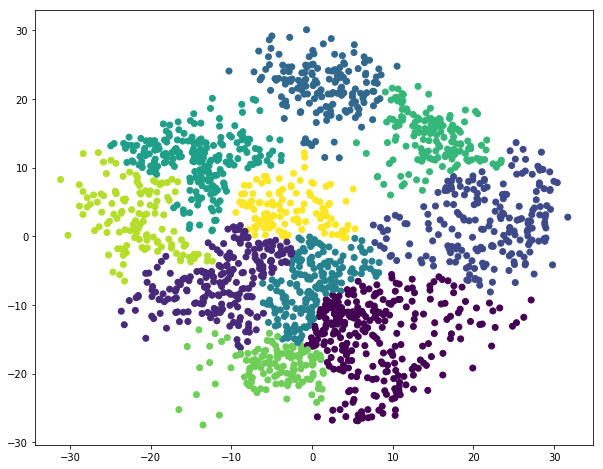

In [5]:
# 利用得到的聚类结果对散点图进行着色
plt.figure(figsize=(10, 8))
plt.scatter(pca_data[:,0], pca_data[:,1],c=cluster_pca)
plt.show()

In [6]:
# 计算聚类过程中的决策边界
x_min, x_max = pca_data[:, 0].min() - 1, pca_data[:, 0].max() + 1
y_min, y_max = pca_data[:, 1].min() - 1, pca_data[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, .4), np.arange(y_min, y_max, .4))
temp_cluster = birch.predict(np.c_[xx.ravel(), yy.ravel()])

# 将决策边界绘制出来
temp_cluster = temp_cluster.reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, temp_cluster, cmap=plt.cm.bwr, alpha=.3)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_pca, s=15)

# 图像参数设置
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

(-28.494449210969673, 31.092202765817223)

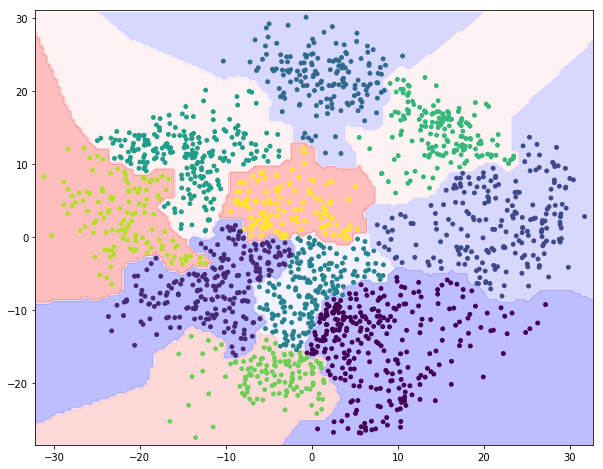

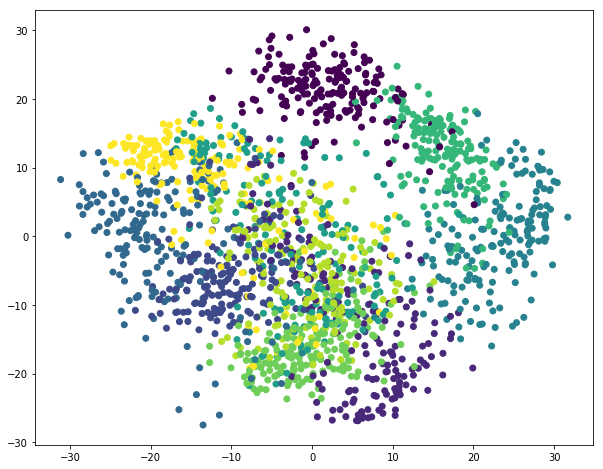

In [7]:
# 可以利用预先知道的各字符对应的标签对散点图进行着色，对比上面的聚类结果
plt.figure(figsize=(10, 8))
plt.scatter(pca_data[:,0], pca_data[:,1],c=digits.target)
plt.show()

- 对照两幅图片，你会发现对`PCA`降维数据的聚类结果大致符合原数据的分布趋势。这里色块的颜色不对应没有关系，因为原标签和聚类标签的顺序不对应，只需要关注数据块的分布规律即可。

- 不过，使用真实标签绘制出来的散点图明显凌乱很多，这其实是由于`PCA`降维造成的。

- 一般情况下，我们输入到聚类模型中的数据不一定要是降维后的数据。下面输入原数据重新聚类试一试。

In [8]:
cluster_ori = birch.fit_predict(digits.data)
cluster_ori

array([7, 9, 4, ..., 4, 1, 4])

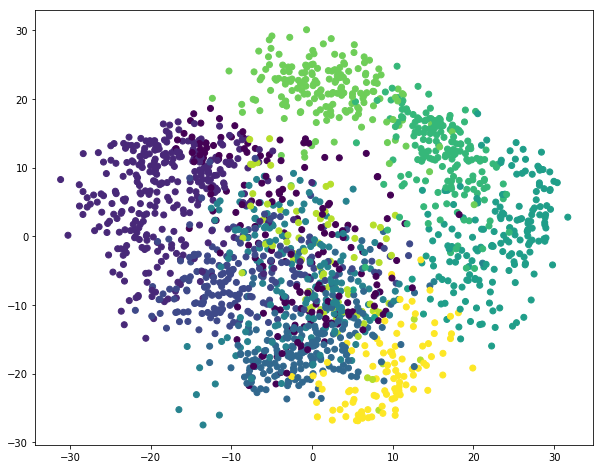

In [15]:
plt.figure(figsize=(10, 8))
plt.scatter(pca_data[:,0], pca_data[:,1],c=cluster_ori)
plt.show()

- 现在你会发现，实验得到的聚类结果更加符合原数据集的分布规律了。再次强调，这里颜色不分离其实是由于`PCA`降维后在二维平面可视化的效果，不代表真实的聚类效果。

- 不过，最后我们再强调一下`PCA`的使用情形。一般情况下，我们不会拿到数据就进行`PCA`处理，只有当算法不尽如人意、训练时间太长、需要可视化等情形才考虑使用`PCA`。其主要原因是，`PCA`被看作是对数据的有损压缩，会造成数据集原始特征丢失。

- 本次我们了解了层次聚类方法，特别地学习了向上、向下以及`BIRCH`算法。其中，比较常用的是自底向上或`BIRCH`方法，且`BIRCH`拥有计算高效的特点。不过，`BIRCH`也有一些弊端，例如对高维数据的聚类效果往往不太好，有时候我们也会使用`Mini Batch K-Means`进行替代。最后，通过表格对比本次实验的3种层次聚类法的优缺点：
